<a href="https://colab.research.google.com/github/zdwhite/Thinkful-Unit-4/blob/master/Unit_4_Lesson_2_Challenge_Boston_Marathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Challenge: Boston Marathon

There is a lot of information on runners and their performance for the Boston Marathon. Pick a year (post-2012 has more info) and do some clustering.

* Use the tools at hand to determine which clustering solution, 
* Including number of clusters and algorithm used is best for the marathon data. 

Once you have a solution you like:
* Write a data story, including visualizations
* Teach the reader something about the Boston Marathon based on your clusters. 
* Write up your report, including your process from start to finish, in a Jupyter notebook and submit it below.

In [0]:
##Imports
## Standard toolkit
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Make Data
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split

#Pre-Processing
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#Clustering Algos
# k-means,Mean-Shift, Spectral, Affinity
from sklearn.cluster import KMeans,MeanShift, estimate_bandwidth,SpectralClustering,AffinityPropagation

#Metrics
from sklearn import metrics

#import cycle
from itertools import cycle

In [3]:
#Display all the columns
pd.set_option('display.max_columns', 500)
df = pd.read_csv('https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv')
df.head()


,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,35k,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,71.40,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,116.37,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,67.42,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,116.37,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,67.83,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 21 columns):
10k          31984 non-null object
name         31984 non-null object
division     31984 non-null int64
25k          31984 non-null object
gender       31984 non-null object
age          31984 non-null int64
official     31984 non-null float64
bib          31984 non-null object
genderdiv    31984 non-null int64
ctz          1244 non-null object
35k          31984 non-null object
overall      31984 non-null int64
pace         31984 non-null float64
state        29408 non-null object
30k          31984 non-null object
5k           31984 non-null object
half         31984 non-null object
20k          31984 non-null object
country      31984 non-null object
city         31983 non-null object
40k          31984 non-null object
dtypes: float64(2), int64(4), object(15)
memory usage: 5.1+ MB


To Do list:
* Clean
  * Nulls
    * State, ctz
  * Encode:
   * gender , bib, state, country, city(?)
  * drop
    * name, bib(?), city(?)
  
 * Visuals
  * Nulls
  *Violin Plot of Splits by Gender
 

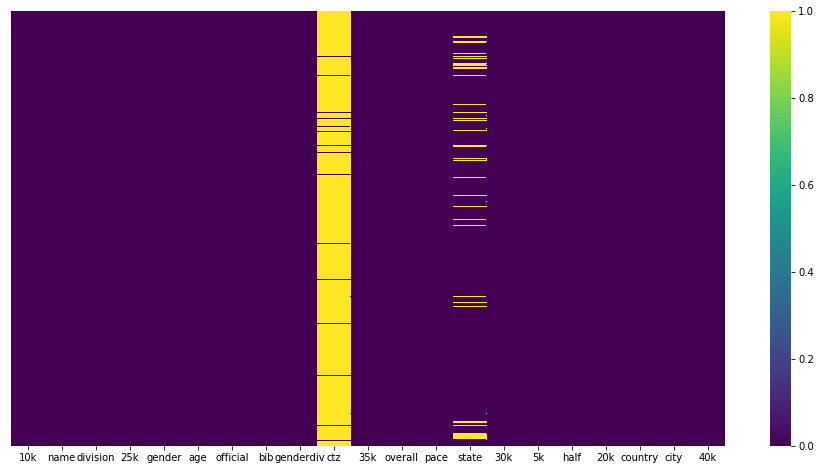

In [5]:
# View missing Data
# Taken from Brandon Madderle (Thanks m8)
plt.figure(figsize=(16,8))
sns.heatmap(df.isnull(), yticklabels=False, cmap='viridis')

In [0]:
df.drop(['name','bib','ctz','state'],1,inplace=True)

Next thing to deal with is the fact that these splits are 
* 1st out of order 
* 2nd are objects which means they are really mixed values and strings

In [7]:
# Re-Order Columns
df = df.reindex(['5k','10k','20k','half', '25k', '30k','35k','40k', 'official', 'pace','division','overall','genderdiv','gender','age','country', 'city'],axis=1)

df.head()

,5k,10k,20k,half,25k,30k,35k,40k,official,pace,division,overall,genderdiv,gender,age,country,city
0,8.02,17.37,37.65,39.72,47.67,59.18,71.40,80.43,85.25,3.27,8,8,8,M,47,JPN,Fukuoka
1,16.22,32.58,65.83,69.47,82.43,99.33,116.37,132.10,138.95,5.30,1,21,1,F,33,KEN,Eldoret
2,7.75,16.62,36.10,38.03,45.80,56.45,67.42,76.10,80.60,3.08,1,1,1,M,41,RSA,Paarl
3,16.20,32.57,65.83,69.47,82.43,99.33,116.37,132.95,140.58,5.37,3,27,3,F,24,ETH,Shoa
4,8.02,17.12,36.58,38.60,46.37,57.03,67.83,76.72,81.23,3.10,2,2,2,M,40,JPN,Nogata Fukuoka


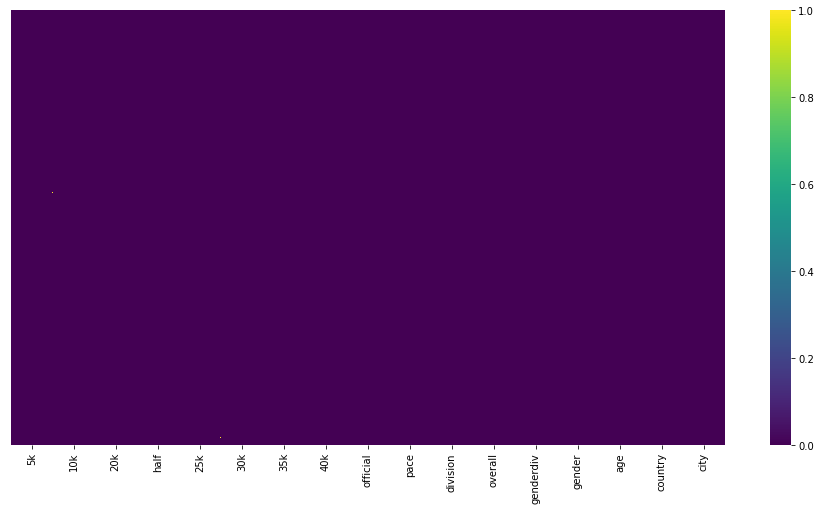

In [8]:
#There are runners that don't have splits, let's visually get a sense of that
#### This graph use to show what splits were missing

no_split = df.apply(lambda x: x.isin(['-']))

plt.figure(figsize=(16,8))
sns.heatmap(no_split, yticklabels=False, cmap='viridis')

In [9]:
print(no_split.sum(),no_split.sum().sum())
print('Percentage of missing splits {}%'.format(no_split.sum().sum()*100/(len(df)*8)))

5k            52
10k           50
20k           51
half          72
25k          216
30k           40
35k           34
40k           39
official       0
pace           0
division       0
overall        0
genderdiv      0
gender         0
age            0
country        0
city           0
dtype: int64 554
Percentage of missing splits 0.2165145072536268%


Time to decide what to do with these missing splits

Either we can 
* just get rid of these people (err) rows
*  impute the data

One thing is for sure, the staff should all be scolded merciliessly DAMN VOLUNTEERS!!

Before we decide let's lay out a plan for both scenarios

1. Drop the missing data
  * Turn the missing splits to nulls and then drop them
  * Next turn those columns to numeric columns
2. Impute the data
  * With respec to imputation here's what you shouldn't do
     * replace the values with 0s or median/mean values
     * Here is why, it's a race so imputing that data with mean values is the same as deleting them because the information is worthless
   * Where does that leave us? Well let's assume there was a lot of missing data, the one thing we have is the distance that was traveled between each split
   For every racer we have a "pace" which in a way is an average or mean split for each individual.
   For a high degree of accuracy one could row by row find the first recorded split for the racer then take their average pace and linearly inpterpolate between each split distance. **I'm not going to do that**, the amount of missing slits is so low with respect to the entire dataset the information "gain" just isn't worth it.
   
DELETING IT IS!


In [0]:
# Lets replace all those strings and move on to what matters
df.replace('-',np.nan,inplace=True)

In [11]:
df.isnull().sum()

5k            52
10k           50
20k           51
half          72
25k          216
30k           40
35k           34
40k           39
official       0
pace           0
division       0
overall        0
genderdiv      0
gender         0
age            0
country        0
city           1
dtype: int64

In [0]:
df.dropna(inplace=True)

In [13]:
df.isnull().sum()

5k           0
10k          0
20k          0
half         0
25k          0
30k          0
35k          0
40k          0
official     0
pace         0
division     0
overall      0
genderdiv    0
gender       0
age          0
country      0
city         0
dtype: int64

In [0]:
df = df.apply(lambda x :pd.to_numeric(x,errors='ignore'))

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31648 entries, 0 to 31983
Data columns (total 17 columns):
5k           31648 non-null float64
10k          31648 non-null float64
20k          31648 non-null float64
half         31648 non-null float64
25k          31648 non-null float64
30k          31648 non-null float64
35k          31648 non-null float64
40k          31648 non-null float64
official     31648 non-null float64
pace         31648 non-null float64
division     31648 non-null int64
overall      31648 non-null int64
genderdiv    31648 non-null int64
gender       31648 non-null object
age          31648 non-null int64
country      31648 non-null object
city         31648 non-null object
dtypes: float64(10), int64(4), object(3)
memory usage: 4.3+ MB


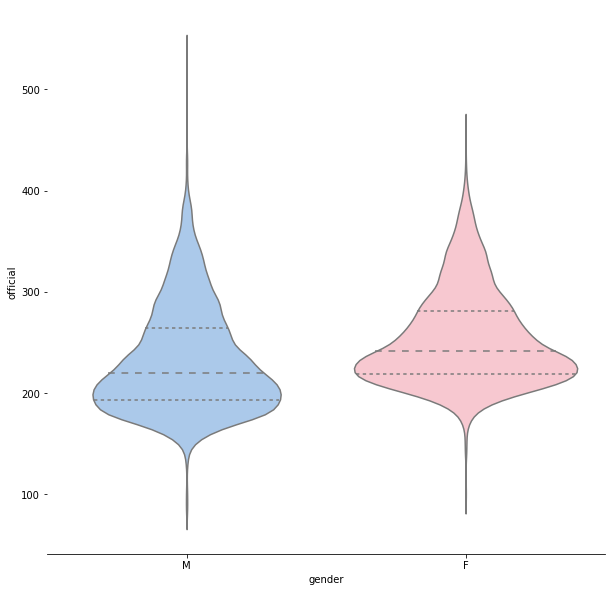

In [15]:

# Violin Plot of Official Times for Men and Women
f, ax = plt.subplots(figsize=(10, 10))
sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.violinplot(x="gender", y= 'official', data=df, split=True,
               inner="quart", palette={"M": "b", "F": "pink"})
sns.despine(left=True)

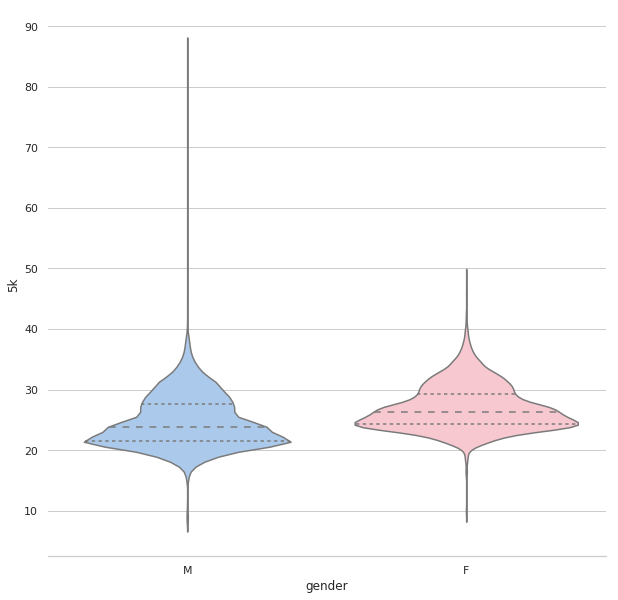

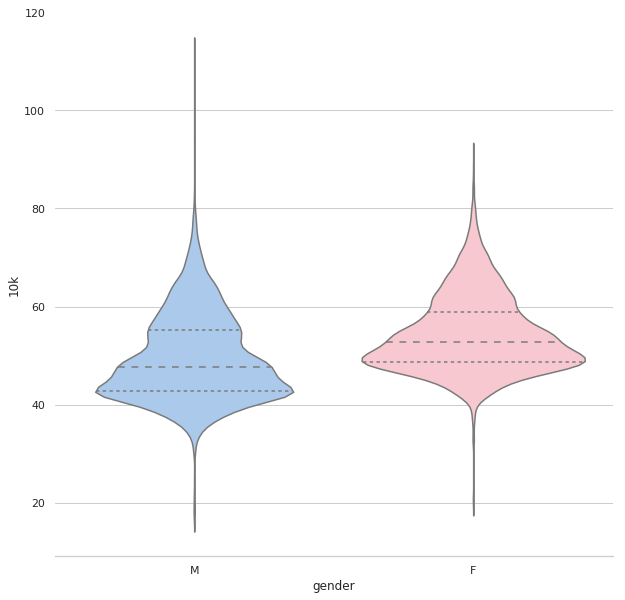

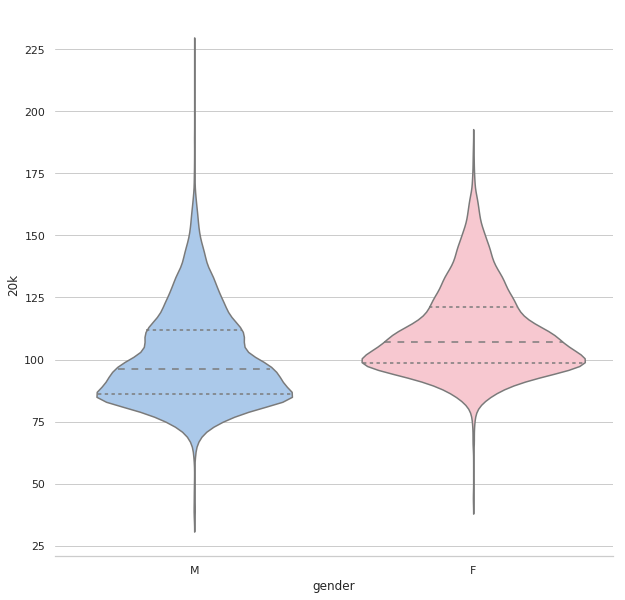

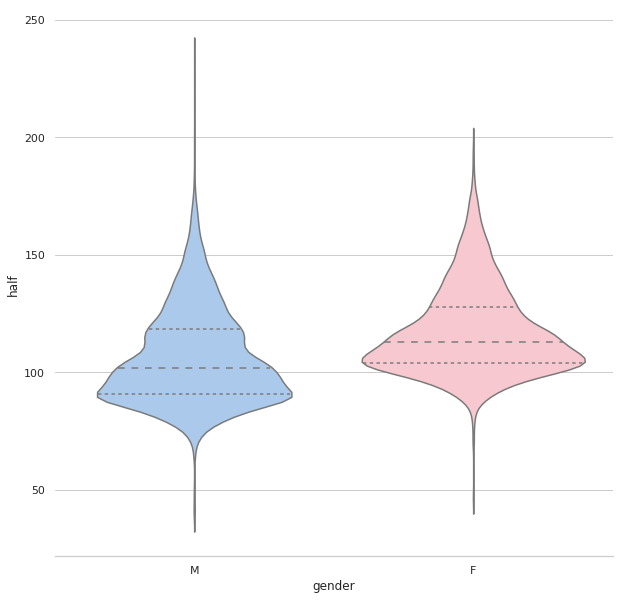

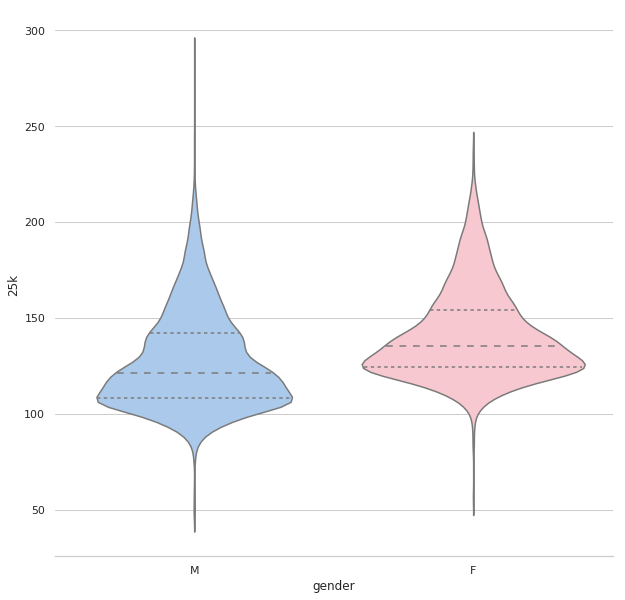

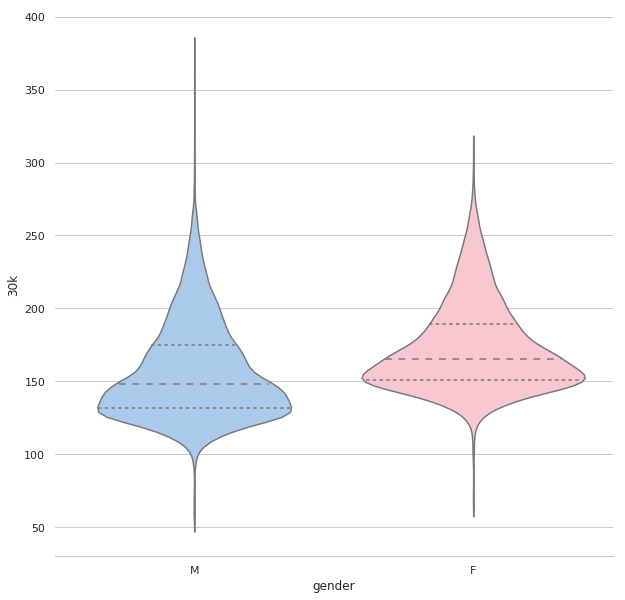

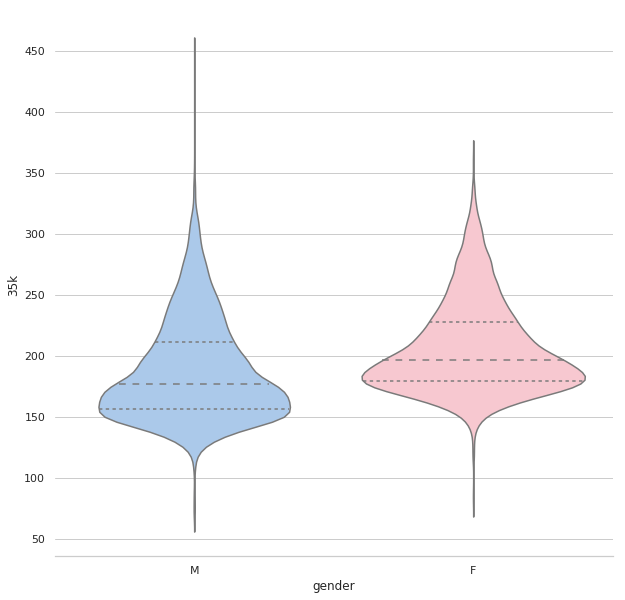

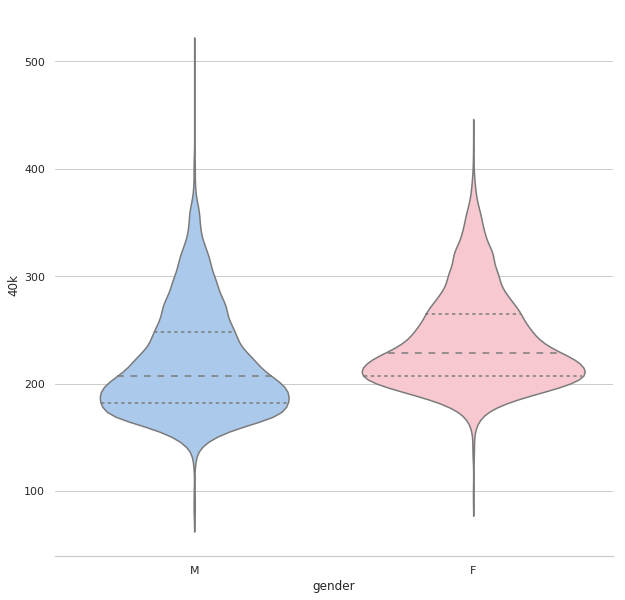

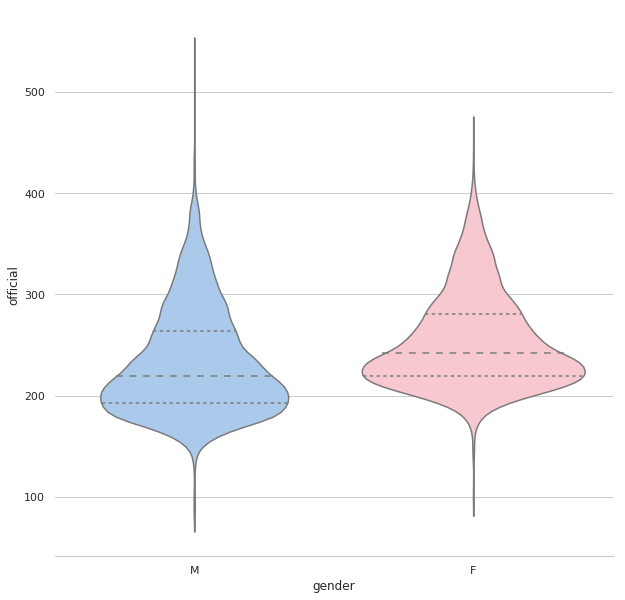

In [16]:
# Gotta get all these graphs on the same axis and the "violins split on gender"
for col in df.columns[:-8]:
  f, ax = plt.subplots(figsize=(10, 10))
  sns.set(style="whitegrid", palette="pastel", color_codes=True)
  sns.violinplot(x="gender", y= col, data=df, split=True,
                 inner="quart", palette={"M": "b", "F": "pink"})
  sns.despine(left=True)

Very interesting outliers going on for the male participants.

Clearly no one is running a marathon below 2 hours. Quickly looking up the top time for runners in 2014 

Keflezighi, Meb won the marathon with a time of 2:08:37 or 128.62 minutes

Let's gate our dataset here at that time

In [17]:
df.describe()

,5k,10k,20k,half,25k,30k,35k,40k,official,pace,division,overall,genderdiv,age
count,31648.000000,31648.000000,31648.000000,31648.000000,31648.000000,31648.000000,31648.000000,31648.000000,31648.000000,31648.000000,31648.000000,31648.000000,31648.000000,31648.000000
mean,25.678275,51.629090,105.321547,111.211631,133.581381,163.895155,196.033725,228.190455,241.952878,9.236483,1922.800367,15834.008658,8003.025404,42.384700
std,4.215447,8.710235,19.159786,20.306691,25.571858,32.889838,40.775632,48.075181,50.843279,1.939178,1704.844465,9182.364552,4733.295012,11.299784
min,7.750000,16.620000,36.100000,38.030000,45.800000,56.450000,67.420000,76.100000,80.600000,3.080000,1.000000,1.000000,1.000000,18.000000
25%,22.620000,45.370000,91.670000,96.750000,115.430000,140.515000,166.950000,193.620000,205.300000,7.830000,607.000000,7879.750000,3940.000000,33.000000
50%,25.050000,50.280000,102.000000,107.680000,128.850000,157.500000,187.850000,218.475000,231.980000,8.850000,1418.000000,15829.500000,7919.000000,42.000000
75%,28.400000,57.000000,116.150000,122.680000,147.700000,182.200000,219.370000,256.570000,272.200000,10.380000,2601.000000,23785.250000,11893.000000,50.000000
max,86.950000,112.380000,224.350000,236.670000,289.020000,376.380000,449.330000,508.350000,538.880000,20.570000,6979.000000,31931.000000,17575.000000,81.000000


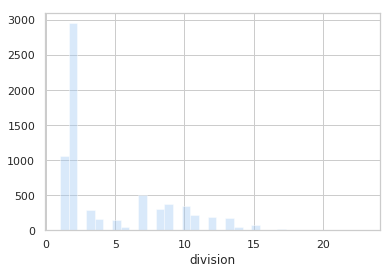

In [18]:
sns.distplot(df['division'].value_counts(),kde=False)

In [0]:
# the fastest running time for the boston marathon was 128 minutes, so any racer who was faster than that won't be considered.
df = df[df['official']>=128]

In [17]:
df.describe()

,5k,10k,20k,half,25k,30k,35k,40k,official,pace,division,overall,genderdiv,age
count,31604.000000,31604.000000,31604.000000,31604.000000,31604.000000,31604.000000,31604.000000,31604.000000,31604.000000,31604.000000,31604.000000,31604.000000,31604.000000,31604.000000
mean,25.701057,51.673333,105.408557,111.303578,133.691724,164.029642,196.194431,228.381464,242.155424,9.244208,1925.457284,15856.021896,8014.145235,42.396659
std,4.173765,8.634823,19.029919,20.169955,25.417169,32.713491,40.574509,47.833842,50.586524,1.929384,1704.542014,9169.768320,4727.190789,11.298866
min,11.730000,25.280000,56.100000,59.100000,71.670000,90.630000,106.620000,121.820000,128.620000,4.920000,1.000000,1.000000,1.000000,18.000000
25%,22.630000,45.380000,91.720000,96.820000,115.500000,140.620000,167.045000,193.727500,205.400000,7.850000,610.000000,7912.750000,3956.750000,33.000000
50%,25.070000,50.300000,102.030000,107.720000,128.900000,157.570000,187.920000,218.570000,232.070000,8.870000,1421.000000,15851.500000,7930.000000,42.000000
75%,28.400000,57.020000,116.180000,122.720000,147.735000,182.270000,219.430000,256.635000,272.280000,10.400000,2604.000000,23796.250000,11898.250000,50.000000
max,86.950000,112.380000,224.350000,236.670000,289.020000,376.380000,449.330000,508.350000,538.880000,20.570000,6979.000000,31931.000000,17575.000000,81.000000


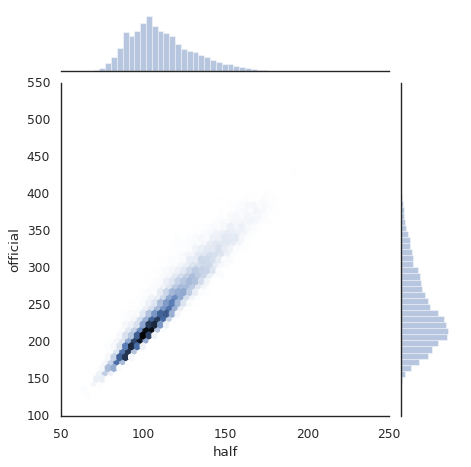

In [40]:
# This Graph gives use a nice sense of the "pack" where most runners are who complete the marathon are half way through with respect to their finishing time.

plt.style.use('classic')
sns.set()
with sns.axes_style('white'):
    g = sns.jointplot("half", "official", df ,kind='hex')
    g.ax_joint.plot(np.linspace(38, 198.6),
                    np.linspace(80.600000, 538.880000), ':k')

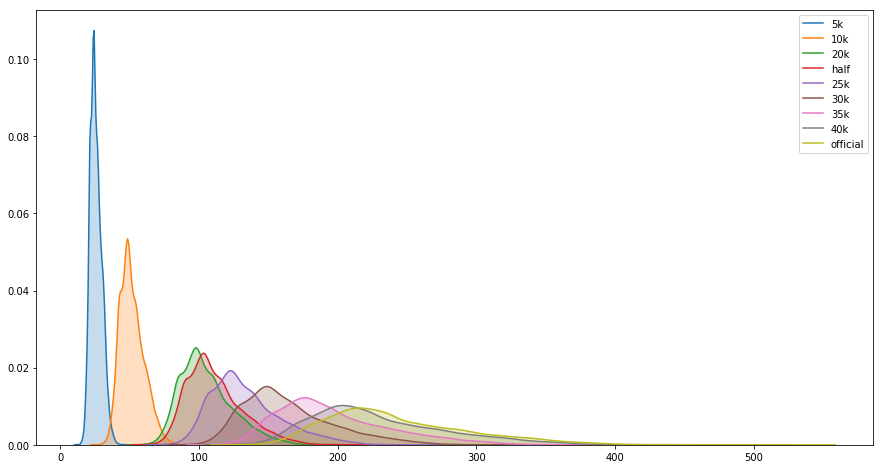

In [18]:
# here is a neat graph that shows how runners are "eager to start" then quickly spread out as the race goes on
plt.subplots(figsize=(15, 8))
for col in df.columns[:-8] :
  sns.kdeplot(df[col], shade=True)

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


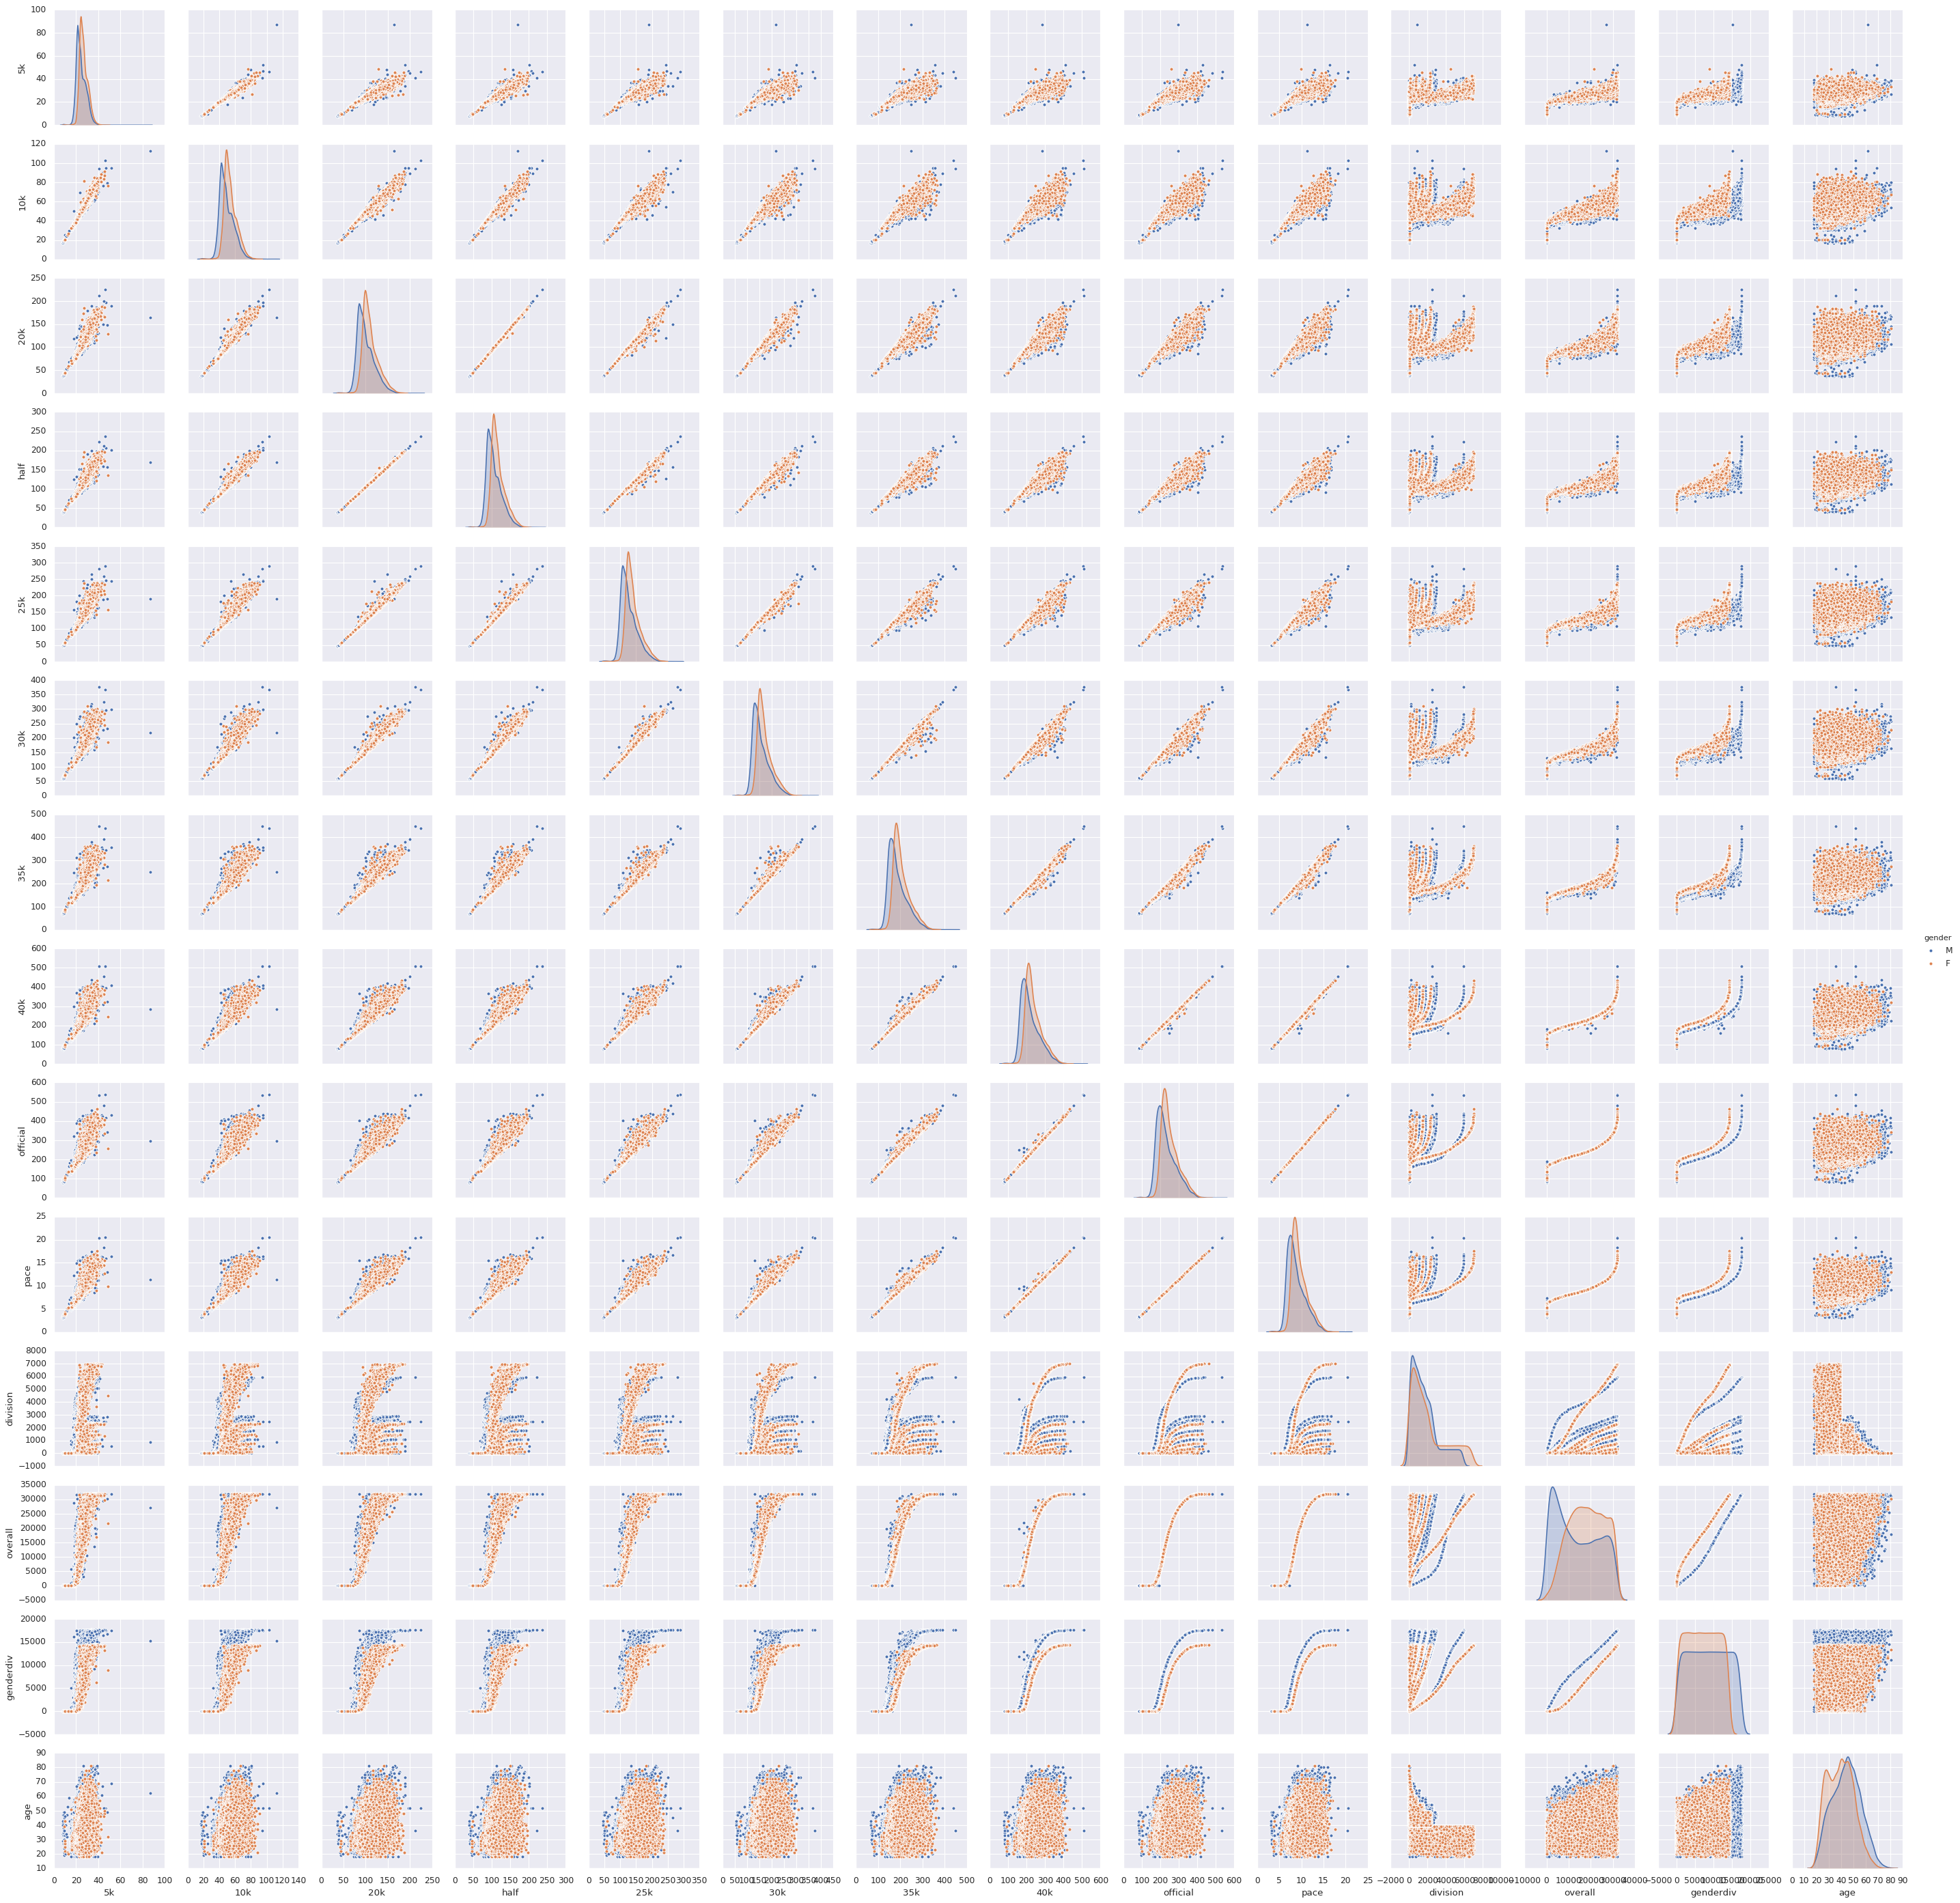

In [22]:
sns.pairplot(df, hue='gender', size=2.5);

In [23]:
!pip install seaborn==0.9.0

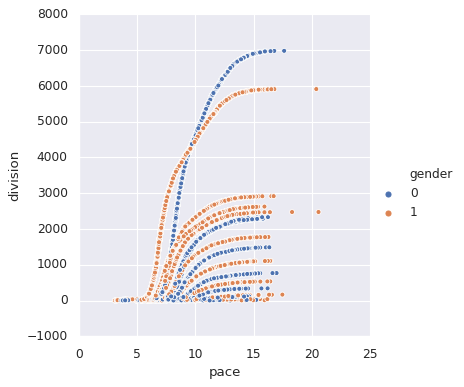

In [32]:
sns.relplot(x='pace',y='division',hue='gender',data=df)

## Feature Encoding

In [19]:
df.head()

,5k,10k,20k,half,25k,30k,35k,40k,official,pace,division,overall,genderdiv,gender,age,country,city
1,16.22,32.58,65.83,69.47,82.43,99.33,116.37,132.10,138.95,5.30,1,21,1,F,33,KEN,Eldoret
3,16.20,32.57,65.83,69.47,82.43,99.33,116.37,132.95,140.58,5.37,3,27,3,F,24,ETH,Shoa
5,16.22,32.58,65.83,69.47,82.45,99.33,116.37,132.95,140.68,5.37,4,28,4,F,29,KEN,Nandi
7,15.17,30.48,61.62,64.85,76.95,92.52,107.47,122.80,129.83,4.97,5,5,5,M,29,ETH,Addis Ababa
9,15.15,30.48,61.78,65.23,77.68,94.78,112.27,129.83,137.83,5.27,20,20,20,M,31,USA,Redding


In [0]:
df.gender = np.where(df.gender == 'M',1,0)
df.country = df.country.astype('category')
df.country = df.country.cat.codes

df.city = df.city.astype('category')
df.city = df.city.cat.codes


In [21]:
df.head()

,5k,10k,20k,half,25k,30k,35k,40k,official,pace,division,overall,genderdiv,gender,age,country,city
1,16.22,32.58,65.83,69.47,82.43,99.33,116.37,132.10,138.95,5.30,1,21,1,0,33,42,1503
3,16.20,32.57,65.83,69.47,82.43,99.33,116.37,132.95,140.58,5.37,3,27,3,0,24,26,4747
5,16.22,32.58,65.83,69.47,82.45,99.33,116.37,132.95,140.68,5.37,4,28,4,0,29,42,3456
7,15.17,30.48,61.62,64.85,76.95,92.52,107.47,122.80,129.83,4.97,5,5,5,1,29,26,23
9,15.15,30.48,61.78,65.23,77.68,94.78,112.27,129.83,137.83,5.27,20,20,20,1,31,73,4259


## Cluster Methods

In [22]:
#http://benalexkeen.com/feature-scaling-with-scikit-learn/
# Standard Scaler vs normalize
from sklearn.metrics import silhouette_score
#df_normalize = normalize(df)

df_normalize = StandardScaler().fit_transform(df)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int8, int16, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int8, int16, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### K-Means

#### Elbow Method and the number of Clusters

<function matplotlib.pyplot.show>

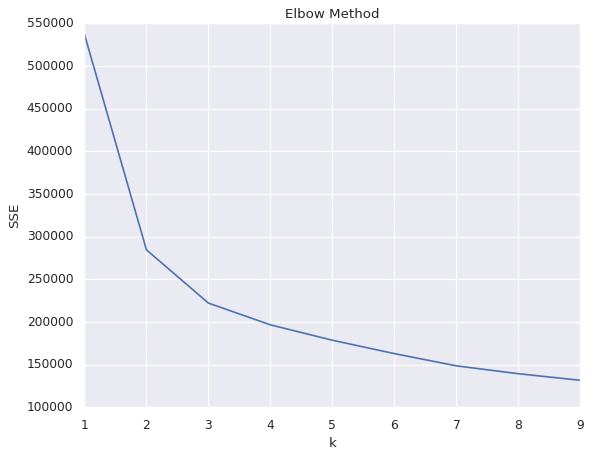

In [44]:
sse = {}
K = range(1,10)
for k in K:
    kmeanmodel = KMeans(n_clusters=k).fit(df_normalize)
    sse[k]= kmeanmodel.inertia_
    
# Plot
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show

In [45]:

for n_cluster in range(2, 7):
    kmeans = KMeans(n_clusters=n_cluster).fit(df_normalize)
    label = kmeans.labels_
    sil_coeff = silhouette_score(df, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))

For n_clusters=2, The Silhouette Coefficient is 0.5013763730346547
For n_clusters=3, The Silhouette Coefficient is 0.4018039855754671
For n_clusters=4, The Silhouette Coefficient is 0.30519127050731154
For n_clusters=5, The Silhouette Coefficient is 0.2555067164785149
For n_clusters=6, The Silhouette Coefficient is 0.22942148098260853


Given the evaluation metric it appears that the Silhouette Coefficient for 2 clusters is the highest.

For n_clusters=2, The Silhouette Coefficient is 0.5013763730346547

For n_clusters=3, The Silhouette Coefficient is 0.4018039855754671

For n_clusters=4, The Silhouette Coefficient is 0.30519127050731154

For n_clusters=5, The Silhouette Coefficient is 0.2555067164785149

For n_clusters=6, The Silhouette Coefficient is 0.22942148098260853


In [0]:
# Calculate predicted values.
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(df_normalize)

In [41]:
plot = plt.scatter(X_train[:, 0], X_train[:, 1], c=y_pred,cmap=plt.cm.jet)

array([4, 4, 4, ..., 2, 1, 3], dtype=int32)

### Spectral Clustering

#### Elbow Method and the number of Clusters

In [1]:
sse = {}
K = range(1,10)
for k in K:
    specmodel = SpectralClustering(n_clusters=k).fit(df_normalize)
    sse[k]= specmodel.inertia_
    
# Plot
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show

NameError: ignored

In [0]:
#Spectral Clustering
for n_cluster in range(2, 7):
    spec = SpectralClustering(n_clusters=n_cluster).fit(df_normalize)
    label = kmeans.labels_
    sil_coeff = silhouette_score(df, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))